In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import math
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import time
import copy
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [6]:
# ================= DATA LOADING =================
# Load signal data
X_signal = np.load("X_train_all.npy")  # (22400, 180) input sinyal
y_all = np.load("y_train_all.npy")     # (22400,) labels

# Load image data 
X_image = np.load("gaf_images2.npy")  # Bisa (22400, 64, 64) atau (22400, 64, 64, 3)

print(f"Signal shape: {X_signal.shape}")
print(f"Image shape: {X_image.shape}")
print(f"Labels shape: {y_all.shape}")

# Preprocessing signal data
X_signal = X_signal.astype("float32")
y_all = y_all.astype("int64")

if X_signal.ndim == 2:
    X_signal = np.expand_dims(X_signal, axis=2)

if X_signal.max() > 1.0:
    X_signal = X_signal / 255.0

# Preprocessing image data
X_image = X_image.astype("float32")
if X_image.max() > 1.0:
    X_image = X_image / 255.0

# Handle different image formats
if len(X_image.shape) == 3:  # Grayscale: (N, H, W)
    print("Detected grayscale images. Converting to 3-channel...")
    X_image = np.stack([X_image, X_image, X_image], axis=-1)  # (N, H, W, 3)
    image_channels = 3
elif len(X_image.shape) == 4:  # Already has channels
    if X_image.shape[-1] == 3:  # (N, H, W, 3)
        image_channels = 3
    elif X_image.shape[1] == 3:  # (N, 3, H, W)
        image_channels = 3
        X_image = np.transpose(X_image, (0, 2, 3, 1))  # Convert to (N, H, W, 3)
    else:
        # Assume grayscale in different format
        print("Converting unknown format to RGB...")
        if X_image.shape[-1] == 1:  # (N, H, W, 1)
            X_image = np.repeat(X_image, 3, axis=-1)  # (N, H, W, 3)
        else:
            X_image = X_image[:, :, :, 0:1]  # Take first channel
            X_image = np.repeat(X_image, 3, axis=-1)  # Convert to RGB
        image_channels = 3

# Convert to PyTorch format: (N, H, W, C) -> (N, C, H, W)
if len(X_image.shape) == 4 and X_image.shape[-1] == 3:
    X_image = np.transpose(X_image, (0, 3, 1, 2))

X_signal_tensor = torch.from_numpy(X_signal)
X_image_tensor = torch.from_numpy(X_image)
y_tensor = torch.from_numpy(y_all)
num_classes = int(np.unique(y_all).size)

print(f"Final signal tensor shape: {X_signal_tensor.shape}")
print(f"Final image tensor shape: {X_image_tensor.shape}")
print(f"Image channels detected: {image_channels}")
print(f"Number of classes: {num_classes}")


Signal shape: (22400, 180)
Image shape: (22400, 64, 64)
Labels shape: (22400,)
Detected grayscale images. Converting to 3-channel...
Final signal tensor shape: torch.Size([22400, 180, 1])
Final image tensor shape: torch.Size([22400, 3, 64, 64])
Image channels detected: 3
Number of classes: 4


In [7]:
# ================= CUSTOM BERT IMPLEMENTATION =================

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        self.scale = math.sqrt(self.d_k)
        
    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        
        # Linear projections in batch from d_model => h x d_k
        Q = self.W_q(query).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(key).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(value).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        
        # Apply attention on all the projected vectors in batch
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
            
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        context = torch.matmul(attn_weights, V)
        
        # Concatenate heads and put through final linear layer
        context = context.transpose(1, 2).contiguous().view(
            batch_size, -1, self.d_model)
        
        output = self.W_o(context)
        return output

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        return self.linear2(self.dropout(F.gelu(self.linear1(x))))

class BERTLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, num_heads, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.ff = FeedForward(d_model, d_ff, dropout)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        # Multi-head attention
        attn_output = self.attention(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        
        # Feed forward
        ff_output = self.ff(x)
        x = self.norm2(x + self.dropout(ff_output))
        
        return x

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                           -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class ECGTokenizer(nn.Module):
    """Convert ECG signal to tokens for BERT processing"""
    def __init__(self, input_dim=1, d_model=768, patch_size=5, max_len=50):
        super().__init__()
        self.patch_size = patch_size
        self.d_model = d_model
        self.max_len = max_len
        
        # Project ECG patches to BERT embedding dimension
        self.patch_embedding = nn.Linear(input_dim * patch_size, d_model)
        
        # Special tokens
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        self.sep_token = nn.Parameter(torch.randn(1, 1, d_model))
        
        # Positional encoding
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        
    def forward(self, x):
        B, L, C = x.shape
        
        # Create patches
        if L % self.patch_size != 0:
            pad_size = self.patch_size - (L % self.patch_size)
            x = torch.cat([x, torch.zeros(B, pad_size, C, device=x.device)], dim=1)
            L = x.shape[1]
        
        num_patches = L // self.patch_size
        patches = x.view(B, num_patches, C * self.patch_size)
        
        # Embed patches
        patch_embeddings = self.patch_embedding(patches)  # [B, num_patches, d_model]
        
        # Add CLS token at the beginning
        cls_tokens = self.cls_token.expand(B, -1, -1)
        embeddings = torch.cat([cls_tokens, patch_embeddings], dim=1)
        
        # Add positional encodings
        embeddings = self.pos_encoding(embeddings)
        
        return embeddings

class CustomBERT(nn.Module):
    """Custom BERT implementation for ECG processing"""
    def __init__(self, input_dim=1, d_model=768, num_heads=12, num_layers=6, 
                 d_ff=3072, dropout=0.1, patch_size=5, max_len=50):
        super().__init__()
        
        # ECG tokenizer
        self.tokenizer = ECGTokenizer(input_dim, d_model, patch_size, max_len)
        
        # BERT layers
        self.layers = nn.ModuleList([
            BERTLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        
        # Final layer norm
        self.layer_norm = nn.LayerNorm(d_model)
        
    def forward(self, x, attention_mask=None):
        # Tokenize ECG signal
        embeddings = self.tokenizer(x)  # [B, seq_len, d_model]
        
        # Pass through BERT layers
        hidden_states = embeddings
        for layer in self.layers:
            hidden_states = layer(hidden_states, attention_mask)
        
        # Final layer norm
        hidden_states = self.layer_norm(hidden_states)
        
        return hidden_states

class BERTBranch(nn.Module):
    """BERT branch for ECG signal processing"""
    def __init__(self, input_dim=1, d_model=768, num_heads=12, num_layers=6, 
                 d_ff=3072, dropout=0.1, patch_size=5, output_dim=128):
        super().__init__()
        
        # Custom BERT model
        self.bert = CustomBERT(
            input_dim=input_dim,
            d_model=d_model,
            num_heads=num_heads,
            num_layers=num_layers,
            d_ff=d_ff,
            dropout=dropout,
            patch_size=patch_size
        )
        
        # Feature projection
        self.feature_projection = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, d_model // 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 4, output_dim)
        )
        
    def forward(self, x):
        # Pass through BERT
        hidden_states = self.bert(x)  # [B, seq_len, d_model]
        
        # Get CLS token representation (first token)
        cls_output = hidden_states[:, 0, :]  # [B, d_model]
        
        # Project to desired feature size
        features = self.feature_projection(cls_output)  # [B, output_dim]
        
        return features

class CNNBranch(nn.Module):
    """CNN branch for image processing"""
    def __init__(self, input_channels=3, num_features=128):
        super().__init__()
        
        self.conv_layers = nn.Sequential(
            # First conv block
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 64x64 -> 32x32
            
            # Second conv block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 32x32 -> 16x16
            
            # Third conv block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 16x16 -> 8x8
            
            # Fourth conv block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((4, 4))  # -> 4x4
        )
        
        # Calculate the flattened size
        self.feature_size = 256 * 4 * 4
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_features)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

class HybridTransformerBERTCNN(nn.Module):
    """Hybrid model combining Custom Transformer-BERT and CNN"""
    def __init__(self, signal_input_dim=1, image_input_channels=3, 
                 d_model=768, num_heads=12, num_layers=6, d_ff=3072,
                 dropout=0.1, num_classes=4, fusion_method='concat', 
                 patch_size=5, feature_dim=128):
        super().__init__()
        
        self.fusion_method = fusion_method
        self.feature_dim = feature_dim
        
        # Custom BERT branch for signal processing
        self.bert_branch = BERTBranch(
            input_dim=signal_input_dim,
            d_model=d_model,
            num_heads=num_heads,
            num_layers=num_layers,
            d_ff=d_ff,
            dropout=dropout,
            patch_size=patch_size,
            output_dim=feature_dim
        )
        
        # CNN branch for image processing
        self.cnn_branch = CNNBranch(
            input_channels=image_input_channels,
            num_features=feature_dim
        )
        
        # Fusion and classification
        if fusion_method == 'concat':
            fusion_input_size = feature_dim * 2  # BERT + CNN features
        elif fusion_method == 'add':
            fusion_input_size = feature_dim
        elif fusion_method == 'attention':
            fusion_input_size = feature_dim
            # Cross-attention between BERT and CNN features
            self.cross_attention = MultiHeadAttention(feature_dim, 8, dropout)
        else:
            raise ValueError("fusion_method must be 'concat', 'add', or 'attention'")
            
        self.fusion_layer = nn.Sequential(
            nn.Linear(fusion_input_size, fusion_input_size // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(fusion_input_size // 2, fusion_input_size // 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(fusion_input_size // 4, num_classes)
        )
        
    def forward(self, signal, image):
        # Process signal through Custom BERT
        signal_features = self.bert_branch(signal)  # [B, feature_dim]
        
        # Process image through CNN
        image_features = self.cnn_branch(image)  # [B, feature_dim]
        
        # Fusion
        if self.fusion_method == 'concat':
            fused_features = torch.cat([signal_features, image_features], dim=1)
        elif self.fusion_method == 'add':
            fused_features = signal_features + image_features
        elif self.fusion_method == 'attention':
            # Cross-attention fusion
            signal_expanded = signal_features.unsqueeze(1)  # [B, 1, feature_dim]
            image_expanded = image_features.unsqueeze(1)    # [B, 1, feature_dim]
            
            # Signal attends to image
            attended_signal = self.cross_attention(signal_expanded, image_expanded, image_expanded)
            fused_features = attended_signal.squeeze(1)  # [B, feature_dim]
            
        # Classification
        logits = self.fusion_layer(fused_features)
        
        return logits

In [8]:
# ================= MULTIMODAL DATASET =================
class MultimodalDataset:
    def __init__(self, signal_data, image_data, labels):
        self.signal_data = signal_data
        self.image_data = image_data
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.signal_data[idx], self.image_data[idx], self.labels[idx]

def create_multimodal_dataloader(signal_data, image_data, labels, batch_size=32, shuffle=True):
    dataset = MultimodalDataset(signal_data, image_data, labels)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=0)


In [9]:
# ================= TRAINING FUNCTIONS =================
def run_epoch_multimodal(model, loader, criterion, optimizer=None, device="cpu"):
    train_mode = optimizer is not None
    model.train() if train_mode else model.eval()
    total_loss, correct, total = 0.0, 0, 0
    y_true, y_pred = [], []
    
    for signal_batch, image_batch, label_batch in loader:
        signal_batch = signal_batch.to(device)
        image_batch = image_batch.to(device)
        label_batch = label_batch.to(device)
        
        if signal_batch.ndim == 2:
            signal_batch = signal_batch.unsqueeze(2)
        
        if train_mode:
            optimizer.zero_grad()
        
        logits = model(signal_batch, image_batch)
        loss = criterion(logits, label_batch)
        
        if train_mode:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        
        total_loss += loss.item()
        correct += (logits.argmax(1) == label_batch).sum().item()
        total += label_batch.size(0)
        
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        y_true.extend(label_batch.cpu().numpy())
        y_pred.extend(preds)
    
    avg_loss = total_loss / len(loader)
    avg_acc = correct / total
    return avg_loss, avg_acc, y_true, y_pred


In [11]:
# ================= TRAINING LOOP =================
def train_hybrid_bert_model(save_dir="checkpoints_hybrid_transformer_bert_cnn"):
    print(f"\n🚀 Training Hybrid Transformer-BERT-CNN Model...")
    print("=" * 60)
    
    os.makedirs(save_dir, exist_ok=True)
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_metrics = []
    per_class_metrics = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_signal_tensor, y_tensor), 1):
        print(f"\n========== Fold {fold}/5 ==========")
        
        # Split data
        X_sig_tr, X_sig_va = X_signal_tensor[train_idx], X_signal_tensor[val_idx]
        X_img_tr, X_img_va = X_image_tensor[train_idx], X_image_tensor[val_idx]
        y_tr, y_va = y_tensor[train_idx], y_tensor[val_idx]

        # Create multimodal dataloaders (smaller batch size for BERT)
        train_loader = create_multimodal_dataloader(X_sig_tr, X_img_tr, y_tr, batch_size=24, shuffle=True)
        val_loader = create_multimodal_dataloader(X_sig_va, X_img_va, y_va, batch_size=24, shuffle=False)

        # Create hybrid BERT model
        model = HybridTransformerBERTCNN(
            signal_input_dim=1,
            image_input_channels=image_channels,
            d_model=512,  # Smaller model for stability
            num_heads=8,
            num_layers=4,
            d_ff=2048,
            dropout=0.1,
            num_classes=num_classes,
            fusion_method='concat',  # Can be 'concat', 'add', or 'attention'
            patch_size=6,
            feature_dim=128
        ).to(device)

        total_params = sum(p.numel() for p in model.parameters())
        print(f"Model parameters: {total_params:,}")

        # Loss and optimizer
        class_weights = compute_class_weight('balanced', classes=np.unique(y_tr.numpy()), y=y_tr.numpy())
        class_weights = torch.FloatTensor(class_weights).to(device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

        train_losses, val_losses = [], []
        train_accuracies, val_accuracies = [], []

        best_val_acc = -1.0
        best_state = None

        # Training for 20 epochs
        for epoch in range(1, 21):
            tr_loss, tr_acc, _, _ = run_epoch_multimodal(model, train_loader, criterion, optimizer, device)
            val_loss, val_acc, y_true_ep, y_pred_ep = run_epoch_multimodal(model, val_loader, criterion, None, device)

            train_losses.append(tr_loss)
            val_losses.append(val_loss)
            train_accuracies.append(tr_acc)
            val_accuracies.append(val_acc)

            print(f"Epoch {epoch:02d}/20 | "
                  f"Train Loss: {tr_loss:.4f} Acc: {tr_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_state = model.state_dict().copy()

        # Save best model
        model.load_state_dict(best_state)
        torch.save(model.state_dict(), os.path.join(save_dir, f"hybrid_transformer_bert_cnn_fold{fold}.pth"))
        print(f"✅ Model saved: hybrid_transformer_bert_cnn_fold{fold}.pth")

        # Final evaluation with memory and inference time measurement
        model.eval()
        y_true, y_pred = [], []
        inference_times = []
        memory_usage = []
        
        with torch.no_grad():
            for signal_batch, image_batch, label_batch in val_loader:
                signal_batch = signal_batch.to(device)
                image_batch = image_batch.to(device)
                
                if signal_batch.ndim == 2:
                    signal_batch = signal_batch.unsqueeze(2)
                
                # Measure inference time
                torch.cuda.synchronize() if torch.cuda.is_available() else None
                start_time = time.perf_counter()
                
                logits = model(signal_batch, image_batch)
                
                torch.cuda.synchronize() if torch.cuda.is_available() else None
                end_time = time.perf_counter()
                
                # Calculate per-sample inference time
                batch_size = signal_batch.size(0)
                inference_time_per_sample = (end_time - start_time) / batch_size
                inference_times.append(inference_time_per_sample)
                
                # Measure memory usage
                if torch.cuda.is_available():
                    gpu_memory = torch.cuda.memory_allocated(device) / 1024**2  # MB
                    memory_usage.append(gpu_memory)
                
                preds = torch.argmax(logits, dim=1).cpu().numpy()
                y_pred.extend(preds)
                y_true.extend(label_batch.numpy())

        # Calculate average metrics
        avg_inference_time = np.mean(inference_times)
        avg_memory_usage = np.mean(memory_usage) if memory_usage else 0
        
        print(f"⚡ Avg Inference Time: {avg_inference_time:.6f} s/sample")
        print(f"💾 Avg GPU Memory: {avg_memory_usage:.2f} MB")

        # Calculate metrics
        report = classification_report(y_true, y_pred, output_dict=True,
                                     target_names=["N", "S", "V", "Q"], zero_division=0)
        cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))

        # Specificity calculation
        cm_sum = cm.sum()
        TP = np.diag(cm)
        FP = cm.sum(axis=0) - TP
        FN = cm.sum(axis=1) - TP
        TN = cm_sum - (TP + FP + FN)
        specificity_per_class = TN / (TN + FP + 1e-8)

        # Save per-class metrics
        for i, cname in enumerate(["N", "S", "V", "Q"]):
            per_class_metrics.append({
                "Fold": f"Fold {fold}",
                "Class": cname,
                "Precision": report[cname]["precision"],
                "Sensitivity": report[cname]["recall"],
                "Specificity": specificity_per_class[i],
                "F1-Score": report[cname]["f1-score"]
            })

        # Fold summary metrics dengan computational metrics
        fold_summary = {
            "Fold": fold,
            "Accuracy": accuracy_score(y_true, y_pred),
            "Precision": precision_score(y_true, y_pred, average="weighted", zero_division=0),
            "Sensitivity": recall_score(y_true, y_pred, average="weighted", zero_division=0),
            "Specificity": specificity_per_class.mean(),
            "F1-Score": f1_score(y_true, y_pred, average="weighted", zero_division=0),
            "Avg_Inference_Time(s)": avg_inference_time,
            "Avg_Memory_Usage(MB)": avg_memory_usage
        }
        fold_metrics.append(fold_summary)

        # Save visualizations per fold
        # Confusion Matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["N", "S", "V", "Q"])
        fig, ax = plt.subplots(figsize=(5.5, 5))
        disp.plot(ax=ax, cmap="Blues", colorbar=False, values_format="d")
        plt.title(f"Confusion Matrix Hybrid Transformer BERT-CNN - Fold {fold}")
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f"hybrid_bert_confusion_matrix_fold{fold}.png"))
        plt.close(fig)

        # Combined training curves
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Accuracy subplot
        ax1.plot(train_accuracies, label="Train Accuracy", linewidth=2)
        ax1.plot(val_accuracies, label="Validation Accuracy", linewidth=2)
        ax1.set_title(f"Accuracy - Fold {fold}", fontsize=12)
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Accuracy")
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Loss subplot
        ax2.plot(train_losses, label="Train Loss", linewidth=2)
        ax2.plot(val_losses, label="Validation Loss", linewidth=2)
        ax2.set_title(f"Loss - Fold {fold}", fontsize=12)
        ax2.set_xlabel("Epoch")
        ax2.set_ylabel("Loss")
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.suptitle(f"Training Progress - Fold {fold} (Hybrid Transformer-BERT-CNN)", fontsize=14)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f"hybrid_bert_combined_curves_fold{fold}.png"), dpi=150)
        plt.close(fig)

        # Individual accuracy curve
        plt.figure(figsize=(8, 6))
        plt.plot(train_accuracies, label="Train Accuracy", linewidth=2)
        plt.plot(val_accuracies, label="Validation Accuracy", linewidth=2)
        plt.title(f"Training and Validation Accuracy - Fold {fold}", fontsize=14)
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f"hybrid_bert_accuracy_fold{fold}.png"), dpi=150)
        plt.close()

        # Individual loss curve
        plt.figure(figsize=(8, 6))
        plt.plot(train_losses, label="Train Loss", linewidth=2)
        plt.plot(val_losses, label="Validation Loss", linewidth=2)
        plt.title(f"Training and Validation Loss - Fold {fold}", fontsize=14)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f"hybrid_bert_loss_fold{fold}.png"), dpi=150)
        plt.close()

        # Clean up GPU memory
        del model, optimizer, train_loader, val_loader
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    # Save results
    df_folds = pd.DataFrame(fold_metrics)
    df_folds.to_csv(os.path.join(save_dir, "fold_summary_metrics_hybrid_bert.csv"), index=False)

    df_per_class = pd.DataFrame(per_class_metrics)
    df_per_class.to_csv(os.path.join(save_dir, "per_class_metrics_hybrid_bert.csv"), index=False)

    # Calculate averages termasuk computational metrics
    df_fold = pd.DataFrame(fold_metrics)
    avg_metrics = df_fold[["Accuracy", "Precision", "Sensitivity", "Specificity", "F1-Score", 
                          "Avg_Inference_Time(s)", "Avg_Memory_Usage(MB)"]].mean(numeric_only=True)

    avg_row = {"Fold": "Average"}
    avg_row.update({k: float(v) for k, v in avg_metrics.to_dict().items()})
    df_fold = pd.concat([df_fold, pd.DataFrame([avg_row])], ignore_index=True)

    df_fold.to_csv(os.path.join(save_dir, "fold_summary_metrics_hybrid_bert_with_average.csv"), index=False)

    print(f"\n✅ Semua model, grafik, dan metrik Hybrid Transformer-BERT-CNN disimpan di folder: {save_dir}")
    
    return df_fold, df_per_class

# ================= EXECUTION =================
print("🚀 Hybrid Transformer-BERT-CNN untuk Input Multimodal (Sinyal + Gambar)")
print("=" * 70)

fold_results, per_class_results = train_hybrid_bert_model()

print("\n📊 Final Results Summary (Hybrid Transformer-BERT-CNN):")
print("=" * 80)
print(fold_results[['Fold', 'Accuracy', 'Precision', 'Sensitivity', 'Specificity', 'F1-Score', 
              'Avg_Inference_Time(s)', 'Avg_Memory_Usage(MB)']].to_string(index=False))

print("\n🔧 Hybrid BERT Model Features:")
print("=" * 50)
print("✅ Custom BERT Branch: Advanced transformer-based temporal pattern extraction")
print("✅ ECG Tokenizer: Converts ECG signals to token sequences for BERT")
print("✅ Multi-Head Attention: 8 attention heads for complex pattern recognition")
print("✅ CNN Branch: Spatial feature extraction from GAF images") 
print("✅ Multimodal Fusion: Concatenation/Addition/Attention fusion options")
print("✅ Balanced Class Weights: Better performance on minority classes")
print("✅ Gradient Clipping: Training stability")
print("✅ AdamW Optimizer: Effective weight decay")
print("✅ Patch-based Processing: ECG signals processed as patches like vision transformers")
print("✅ GELU Activation: Better gradient flow than ReLU")
print("✅ Layer Normalization: Training stability and faster convergence")

print("\n✅ HYBRID BERT TRAINING COMPLETED!")
print(f"Check 'checkpoints_hybrid_transformer_bert_cnn' folder for results.")
print(f"🎯 Expected: Higher accuracy with better temporal understanding via Custom BERT")

🚀 Hybrid Transformer-BERT-CNN untuk Input Multimodal (Sinyal + Gambar)

🚀 Training Hybrid Transformer-BERT-CNN Model...

========== Fold 1/5 ==========
Model parameters: 15,488,580
Epoch 01/20 | Train Loss: 0.2697 Acc: 0.9117 | Val Loss: 0.1796 Acc: 0.9469
Epoch 02/20 | Train Loss: 0.1604 Acc: 0.9501 | Val Loss: 0.1439 Acc: 0.9614
Epoch 03/20 | Train Loss: 0.1305 Acc: 0.9610 | Val Loss: 0.1659 Acc: 0.9453
Epoch 04/20 | Train Loss: 0.1165 Acc: 0.9651 | Val Loss: 0.1582 Acc: 0.9542
Epoch 05/20 | Train Loss: 0.1043 Acc: 0.9693 | Val Loss: 0.1467 Acc: 0.9614
Epoch 06/20 | Train Loss: 0.0977 Acc: 0.9710 | Val Loss: 0.1379 Acc: 0.9674
Epoch 07/20 | Train Loss: 0.0863 Acc: 0.9753 | Val Loss: 0.1131 Acc: 0.9746
Epoch 08/20 | Train Loss: 0.0809 Acc: 0.9775 | Val Loss: 0.1109 Acc: 0.9757
Epoch 09/20 | Train Loss: 0.0892 Acc: 0.9777 | Val Loss: 0.1185 Acc: 0.9710
Epoch 10/20 | Train Loss: 0.0740 Acc: 0.9800 | Val Loss: 0.1078 Acc: 0.9783
Epoch 11/20 | Train Loss: 0.0641 Acc: 0.9833 | Val Loss: 0.

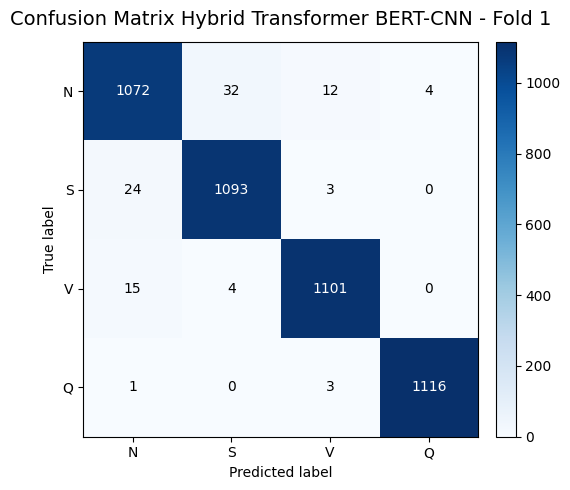

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

# === Folder simpan ===
save_dir = "checkpoints_hybrid_transformer_bert_cnn"
os.makedirs(save_dir, exist_ok=True)

# Confusion matrix (Hybrid Transformer BERT-CNN - Fold 1)
cm = np.array([
    [1072,  32,  12,   4],  # True N
    [  24, 1093,  3,   0],  # True S
    [  15,   4, 1101,  0],  # True V
    [   1,   0,   3, 1116]  # True Q
], dtype=int)

classes = ['N', 'S', 'V', 'Q']

# Plot sederhana tanpa grid
fig, ax = plt.subplots(figsize=(5.5, 5))
im = ax.imshow(cm, cmap='Blues', interpolation='nearest')

ax.set_title('Confusion Matrix Hybrid Transformer BERT-CNN - Fold 1', pad=12, fontsize=14)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

# Colorbar
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Anotasi nilai di tiap sel
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f'{cm[i, j]}',
                ha='center', va='center',
                color='white' if cm[i, j] > thresh else 'black',
                fontsize=10)

plt.tight_layout()

# Simpan gambar
out_path = os.path.join(save_dir, 'hybrid_transformer_bert_cnn_nontuning_confusionmatrix_fold1.png')
plt.savefig(out_path, dpi=150, bbox_inches='tight')
plt.show()


In [ ]:
EXTERNAL TEST

🚀 External Test - Hybrid Transformer-BERT-CNN
Using device: cuda
Model checkpoint: checkpoints_hybrid_transformer_bert_cnn/hybrid_transformer_bert_cnn_fold1.pth
📊 External test data loaded:
Signal shape: (5600, 180)
Image shape: (5600, 64, 64)
Labels shape: (5600,)
Class distribution: [1400 1400 1400 1400]
Detected grayscale images. Converting to 3-channel...
Final signal shape: (5600, 180, 1)
Final image shape: (5600, 3, 64, 64)
Image channels: 3
🔧 Loading Hybrid Transformer-BERT-CNN model...
✅ Hybrid Transformer-BERT-CNN model loaded successfully!
🔍 Starting evaluation on external test set...


Evaluasi External Test Set Hybrid BERT: 100%|██████████| 175/175 [00:00<00:00, 229.42it/s]



=== 📊 EVALUASI EXTERNAL TEST SET - HYBRID TRANSFORMER-BERT-CNN ===
              precision    recall  f1-score   support

           N   0.927934  0.965714  0.946447      1400
           S   0.967669  0.919286  0.942857      1400
           V   0.980865  0.988571  0.984703      1400
           Q   0.997147  0.998571  0.997859      1400

    accuracy                       0.968036      5600
   macro avg   0.968404  0.968036  0.967967      5600
weighted avg   0.968404  0.968036  0.967967      5600



<Figure size 800x600 with 0 Axes>

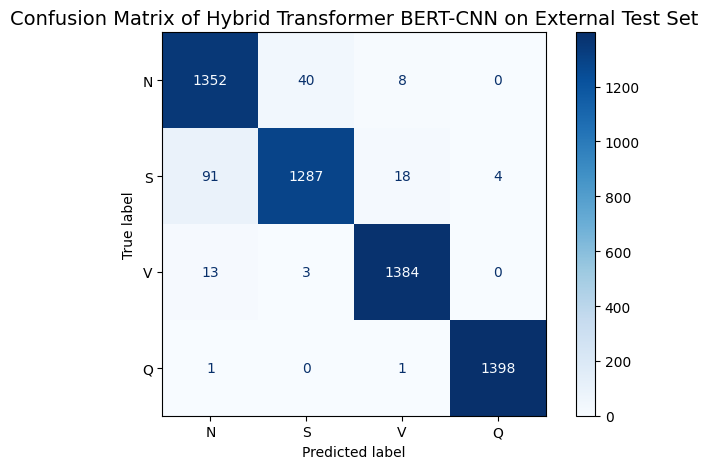

✅ Confusion matrix disimpan ke: hybrid_transformer_bert_cnn_non_tuning_external_outputs/confusion_matrix_external_hybrid_bert.png

=== 📈 RINGKASAN EVALUASI (EXTERNAL TEST SET) ===
🎯 Accuracy   : 0.968036
🎯 Precision  : 0.968404
🎯 Sensitivity: 0.968036
🎯 Specificity: 0.989345
🎯 F1-Score   : 0.967967
⚡ Avg Inference Time: 0.000102 s/sample
💾 Avg Memory Usage: 136.28 MB

📁 CSV files saved:
   - hybrid_transformer_bert_cnn_non_tuning_external_outputs/external_summary_metrics_hybrid_bert.csv
   - hybrid_transformer_bert_cnn_non_tuning_external_outputs/external_per_class_metrics_hybrid_bert.csv

🔄 Calculating ROC-AUC...
📊 AUC Macro  : 0.996473
📊 AUC Micro  : 0.997400

💾 Model Information:
   - CPU Memory: 2899.65 MB
   - Model Size: 59.19 MB
   - Total Parameters: 15,488,580

🎉 EXTERNAL TEST EVALUATION COMPLETED!
📁 Results saved in: hybrid_transformer_bert_cnn_non_tuning_external_outputs
📊 Overall Accuracy: 0.9680
📊 F1-Score: 0.9680
📊 AUC Macro: 0.9965

🔍 HYBRID BERT MODEL ADVANTAGES:
✅ Cust

In [17]:
# EXTERNAL TEST - Hybrid Transformer-BERT-CNN

import os, time, numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import (classification_report, confusion_matrix,
                             ConfusionMatrixDisplay, accuracy_score,
                             precision_score, recall_score, f1_score,
                             roc_auc_score)
import pandas as pd
from tqdm import tqdm

# ====== Config ======
BATCH_SIZE    = 32  # Smaller batch for BERT
NUM_CLASSES   = 4
CLASS_NAMES   = ['N', 'S', 'V', 'Q']
DEVICE        = "cuda" if torch.cuda.is_available() else "cpu"

# Hybrid Transformer-BERT-CNN fold terbaik
CKPT_PATH     = "checkpoints_hybrid_transformer_bert_cnn/hybrid_transformer_bert_cnn_fold1.pth"
X_SIG_PATH    = "X_test_final.npy"      # Sinyal input test
X_IMG_PATH    = "gaf_images_test.npy"  # Gambar input test
Y_LABEL_PATH  = "y_test_final.npy"      # Label test

OUT_DIR       = "hybrid_transformer_bert_cnn_non_tuning_external_outputs"
os.makedirs(OUT_DIR, exist_ok=True)
SAVE_CM_PNG   = os.path.join(OUT_DIR, "confusion_matrix_external_hybrid_bert.png")
SAVE_REPORT   = os.path.join(OUT_DIR, "classification_report_external_hybrid_bert.txt")
SAVE_SUMMARY  = os.path.join(OUT_DIR, "external_summary_metrics_hybrid_bert.csv")
SAVE_PERCLS   = os.path.join(OUT_DIR, "external_per_class_metrics_hybrid_bert.csv")

print(f"🚀 External Test - Hybrid Transformer-BERT-CNN")
print(f"Using device: {DEVICE}")
print(f"Model checkpoint: {CKPT_PATH}")

# ====== Load External Test Set ======
X_signal = np.load(X_SIG_PATH)  # (N, L) sinyal
X_image = np.load(X_IMG_PATH)   # (N, H, W) atau (N, H, W, C) gambar
y_label = np.load(Y_LABEL_PATH)

print(f"📊 External test data loaded:")
print(f"Signal shape: {X_signal.shape}")
print(f"Image shape: {X_image.shape}")
print(f"Labels shape: {y_label.shape}")
print(f"Class distribution: {np.bincount(y_label)}")

# ====== Preprocessing Signal Data ======
X_signal = X_signal.astype("float32")
if X_signal.max() > 1.0 or X_signal.min() < 0.0:
    gmax, gmin = X_signal.max(), X_signal.min()
    if gmax != gmin:
        X_signal = (X_signal - gmin) / (gmax - gmin)
        print(f"🔧 Signal normalized: [{gmin:.3f}, {gmax:.3f}] -> [0, 1]")

if X_signal.ndim == 2:
    X_signal = np.expand_dims(X_signal, axis=2)

# ====== Preprocessing Image Data ======
X_image = X_image.astype("float32")
if X_image.max() > 1.0:
    X_image = X_image / 255.0
    print(f"🔧 Images normalized to [0, 1]")

# Handle different image formats (same as training)
if len(X_image.shape) == 3:  # Grayscale: (N, H, W)
    print("Detected grayscale images. Converting to 3-channel...")
    X_image = np.stack([X_image, X_image, X_image], axis=-1)  # (N, H, W, 3)
    image_channels = 3
elif len(X_image.shape) == 4:  # Already has channels
    if X_image.shape[-1] == 3:  # (N, H, W, 3)
        image_channels = 3
    elif X_image.shape[1] == 3:  # (N, 3, H, W)
        image_channels = 3
        X_image = np.transpose(X_image, (0, 2, 3, 1))  # Convert to (N, H, W, 3)
    else:
        # Assume grayscale in different format
        print("Converting unknown format to RGB...")
        if X_image.shape[-1] == 1:  # (N, H, W, 1)
            X_image = np.repeat(X_image, 3, axis=-1)  # (N, H, W, 3)
        else:
            X_image = X_image[:, :, :, 0:1]  # Take first channel
            X_image = np.repeat(X_image, 3, axis=-1)  # Convert to RGB
        image_channels = 3

# Convert to PyTorch format: (N, H, W, C) -> (N, C, H, W)
if len(X_image.shape) == 4 and X_image.shape[-1] == 3:
    X_image = np.transpose(X_image, (0, 3, 1, 2))

print(f"Final signal shape: {X_signal.shape}")
print(f"Final image shape: {X_image.shape}")
print(f"Image channels: {image_channels}")

# Konversi ke tensor
X_signal_t = torch.tensor(X_signal, dtype=torch.float32)
X_image_t = torch.tensor(X_image, dtype=torch.float32)
y_label_t = torch.tensor(y_label, dtype=torch.long)

# ====== Multimodal Dataset untuk Test ======
class MultimodalTestDataset:
    def __init__(self, signal_data, image_data, labels):
        self.signal_data = signal_data
        self.image_data = image_data
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.signal_data[idx], self.image_data[idx], self.labels[idx]

test_dataset = MultimodalTestDataset(X_signal_t, X_image_t, y_label_t)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# ====== Custom BERT Components ======
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        self.scale = math.sqrt(self.d_k)
        
    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        
        Q = self.W_q(query).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(key).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(value).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
            
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        context = torch.matmul(attn_weights, V)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        output = self.W_o(context)
        return output

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        return self.linear2(self.dropout(F.gelu(self.linear1(x))))

class BERTLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, num_heads, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.ff = FeedForward(d_model, d_ff, dropout)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        attn_output = self.attention(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.ff(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class ECGTokenizer(nn.Module):
    def __init__(self, input_dim=1, d_model=768, patch_size=5, max_len=50):
        super().__init__()
        self.patch_size = patch_size
        self.d_model = d_model
        self.max_len = max_len
        
        self.patch_embedding = nn.Linear(input_dim * patch_size, d_model)
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        self.sep_token = nn.Parameter(torch.randn(1, 1, d_model))
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        
    def forward(self, x):
        B, L, C = x.shape
        
        if L % self.patch_size != 0:
            pad_size = self.patch_size - (L % self.patch_size)
            x = torch.cat([x, torch.zeros(B, pad_size, C, device=x.device)], dim=1)
            L = x.shape[1]
        
        num_patches = L // self.patch_size
        patches = x.view(B, num_patches, C * self.patch_size)
        patch_embeddings = self.patch_embedding(patches)
        
        cls_tokens = self.cls_token.expand(B, -1, -1)
        embeddings = torch.cat([cls_tokens, patch_embeddings], dim=1)
        embeddings = self.pos_encoding(embeddings)
        
        return embeddings

class CustomBERT(nn.Module):
    def __init__(self, input_dim=1, d_model=768, num_heads=12, num_layers=6, 
                 d_ff=3072, dropout=0.1, patch_size=5, max_len=50):
        super().__init__()
        
        self.tokenizer = ECGTokenizer(input_dim, d_model, patch_size, max_len)
        self.layers = nn.ModuleList([
            BERTLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        self.layer_norm = nn.LayerNorm(d_model)
        
    def forward(self, x, attention_mask=None):
        embeddings = self.tokenizer(x)
        hidden_states = embeddings
        for layer in self.layers:
            hidden_states = layer(hidden_states, attention_mask)
        hidden_states = self.layer_norm(hidden_states)
        return hidden_states

class BERTBranch(nn.Module):
    def __init__(self, input_dim=1, d_model=768, num_heads=12, num_layers=6, 
                 d_ff=3072, dropout=0.1, patch_size=5, output_dim=128):
        super().__init__()
        
        self.bert = CustomBERT(
            input_dim=input_dim, d_model=d_model, num_heads=num_heads,
            num_layers=num_layers, d_ff=d_ff, dropout=dropout, patch_size=patch_size
        )
        
        self.feature_projection = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, d_model // 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 4, output_dim)
        )
        
    def forward(self, x):
        hidden_states = self.bert(x)
        cls_output = hidden_states[:, 0, :]
        features = self.feature_projection(cls_output)
        return features

class CNNBranch(nn.Module):
    """CNN branch for image processing"""
    def __init__(self, input_channels=3, num_features=128):
        super().__init__()
        
        self.conv_layers = nn.Sequential(
            # First conv block
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 64x64 -> 32x32
            
            # Second conv block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 32x32 -> 16x16
            
            # Third conv block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 16x16 -> 8x8
            
            # Fourth conv block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((4, 4))  # -> 4x4
        )
        
        # Calculate the flattened size
        self.feature_size = 256 * 4 * 4
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_features)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

class HybridTransformerBERTCNN(nn.Module):
    """Hybrid model combining Custom Transformer-BERT and CNN"""
    def __init__(self, signal_input_dim=1, image_input_channels=3, 
                 d_model=768, num_heads=12, num_layers=6, d_ff=3072,
                 dropout=0.1, num_classes=4, fusion_method='concat', 
                 patch_size=5, feature_dim=128):
        super().__init__()
        
        self.fusion_method = fusion_method
        self.feature_dim = feature_dim
        
        # Custom BERT branch for signal processing
        self.bert_branch = BERTBranch(
            input_dim=signal_input_dim, d_model=d_model, num_heads=num_heads,
            num_layers=num_layers, d_ff=d_ff, dropout=dropout, 
            patch_size=patch_size, output_dim=feature_dim
        )
        
        # CNN branch for image processing
        self.cnn_branch = CNNBranch(
            input_channels=image_input_channels, num_features=feature_dim
        )
        
        # Fusion and classification
        if fusion_method == 'concat':
            fusion_input_size = feature_dim * 2  # BERT + CNN features
        elif fusion_method == 'add':
            fusion_input_size = feature_dim
        elif fusion_method == 'attention':
            fusion_input_size = feature_dim
            self.cross_attention = MultiHeadAttention(feature_dim, 8, dropout)
        else:
            raise ValueError("fusion_method must be 'concat', 'add', or 'attention'")
            
        self.fusion_layer = nn.Sequential(
            nn.Linear(fusion_input_size, fusion_input_size // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(fusion_input_size // 2, fusion_input_size // 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(fusion_input_size // 4, num_classes)
        )
        
    def forward(self, signal, image):
        # Process signal through Custom BERT
        signal_features = self.bert_branch(signal)  # [B, feature_dim]
        
        # Process image through CNN
        image_features = self.cnn_branch(image)  # [B, feature_dim]
        
        # Fusion
        if self.fusion_method == 'concat':
            fused_features = torch.cat([signal_features, image_features], dim=1)
        elif self.fusion_method == 'add':
            fused_features = signal_features + image_features
        elif self.fusion_method == 'attention':
            signal_expanded = signal_features.unsqueeze(1)
            image_expanded = image_features.unsqueeze(1)
            attended_signal = self.cross_attention(signal_expanded, image_expanded, image_expanded)
            fused_features = attended_signal.squeeze(1)
            
        # Classification
        logits = self.fusion_layer(fused_features)
        
        return logits

# ====== Load Hybrid BERT Model ======
print(f"🔧 Loading Hybrid Transformer-BERT-CNN model...")

model = HybridTransformerBERTCNN(
    signal_input_dim=1,
    image_input_channels=image_channels,
    d_model=512,  # Same as training
    num_heads=8,
    num_layers=4,
    d_ff=2048,
    dropout=0.1,
    num_classes=NUM_CLASSES,
    fusion_method='concat',
    patch_size=6,
    feature_dim=128
).to(DEVICE)

if not os.path.exists(CKPT_PATH):
    raise FileNotFoundError(f"❌ Checkpoint tidak ditemukan: {CKPT_PATH}")

state = torch.load(CKPT_PATH, map_location=DEVICE)
if isinstance(state, dict) and 'state_dict' in state:
    state = state['state_dict']
state = {k.replace("module.", ""): v for k, v in state.items()}
model.load_state_dict(state, strict=True)
model.eval()

print(f"✅ Hybrid Transformer-BERT-CNN model loaded successfully!")

# ====== Evaluate ======
print(f"🔍 Starting evaluation on external test set...")
all_preds, all_labels, all_logits = [], [], []
inference_times = []
memory_usage = []

with torch.no_grad():
    for signal_batch, image_batch, label_batch in tqdm(test_loader, desc="Evaluasi External Test Set Hybrid BERT"):
        signal_batch = signal_batch.to(DEVICE)
        image_batch = image_batch.to(DEVICE)
        label_batch = label_batch.to(DEVICE)

        if signal_batch.ndim == 2:
            signal_batch = signal_batch.unsqueeze(2)

        # Measure inference time
        torch.cuda.synchronize() if torch.cuda.is_available() else None
        t0 = time.perf_counter()
        
        logits = model(signal_batch, image_batch)
        
        torch.cuda.synchronize() if torch.cuda.is_available() else None
        t1 = time.perf_counter()

        # Calculate per-sample inference time
        batch_size = signal_batch.size(0)
        inference_time_per_sample = (t1 - t0) / batch_size
        inference_times.append(inference_time_per_sample)

        # Measure memory usage
        if torch.cuda.is_available():
            gpu_memory = torch.cuda.memory_allocated(DEVICE) / 1024**2  # MB
            memory_usage.append(gpu_memory)

        preds = torch.argmax(logits, dim=1)

        all_logits.append(logits.cpu())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(label_batch.cpu().numpy())

# Menggabungkan hasil
all_logits = torch.cat(all_logits, dim=0)
y_probs = torch.softmax(all_logits, dim=1).numpy()
y_true  = np.array(all_labels)
y_pred  = np.array(all_preds)

# ====== Report & Confusion Matrix ======
report_txt = classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=6)
print("\n" + "="*70)
print("=== 📊 EVALUASI EXTERNAL TEST SET - HYBRID TRANSFORMER-BERT-CNN ===")
print("="*70)
print(report_txt)

with open(SAVE_REPORT, "w") as f:
    f.write("=== EVALUASI EXTERNAL TEST SET - HYBRID TRANSFORMER-BERT-CNN ===\n")
    f.write("="*60 + "\n")
    f.write(report_txt)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred, display_labels=CLASS_NAMES, cmap="Blues", values_format="d"
)
plt.title("Confusion Matrix of Hybrid Transformer BERT-CNN on External Test Set", fontsize=14)
plt.tight_layout()
plt.savefig(SAVE_CM_PNG, dpi=150)
plt.show()
print(f"✅ Confusion matrix disimpan ke: {SAVE_CM_PNG}")

# ====== Ringkasan Metrics ======
acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average="weighted", zero_division=0)
rec  = recall_score(y_true, y_pred, average="weighted", zero_division=0)
f1   = f1_score(y_true, y_pred, average="weighted", zero_division=0)

cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (TP + FP + FN)
spec_per_cls = TN / (TN + FP + 1e-8)
spec_mean = spec_per_cls.mean()

avg_inference_time = float(np.mean(inference_times)) if inference_times else np.nan
avg_memory_usage = float(np.mean(memory_usage)) if memory_usage else 0

print("\n" + "="*60)
print("=== 📈 RINGKASAN EVALUASI (EXTERNAL TEST SET) ===")
print("="*60)
print(f"🎯 Accuracy   : {acc:.6f}")
print(f"🎯 Precision  : {prec:.6f}")
print(f"🎯 Sensitivity: {rec:.6f}")
print(f"🎯 Specificity: {spec_mean:.6f}")
print(f"🎯 F1-Score   : {f1:.6f}")
print(f"⚡ Avg Inference Time: {avg_inference_time:.6f} s/sample")
print(f"💾 Avg Memory Usage: {avg_memory_usage:.2f} MB")

# Simpan summary CSV
summary_df = pd.DataFrame([{
    "Model": "Hybrid_Transformer_BERT_CNN",
    "Accuracy": acc, 
    "Precision": prec, 
    "Sensitivity": rec,
    "Specificity": float(spec_mean), 
    "F1-Score": f1,
    "AvgInference(s/sample)": avg_inference_time,
    "AvgMemory(MB)": avg_memory_usage
}])
summary_df.to_csv(SAVE_SUMMARY, index=False)

# Per-class metrics dengan perhitungan yang benar
percls_metrics = []
for i, class_name in enumerate(CLASS_NAMES):
    # Binary classification untuk setiap kelas
    y_true_binary = (y_true == i).astype(int)
    y_pred_binary = (y_pred == i).astype(int)
    
    prec_cls = precision_score(y_true_binary, y_pred_binary, zero_division=0)
    rec_cls = recall_score(y_true_binary, y_pred_binary, zero_division=0)
    f1_cls = f1_score(y_true_binary, y_pred_binary, zero_division=0)
    spec_cls = spec_per_cls[i]
    
    percls_metrics.append({
        "Class": class_name,
        "Precision": prec_cls,
        "Sensitivity": rec_cls,
        "Specificity": spec_cls,
        "F1-Score": f1_cls
    })

percls_df = pd.DataFrame(percls_metrics)
percls_df.to_csv(SAVE_PERCLS, index=False)

print(f"\n📁 CSV files saved:")
print(f"   - {SAVE_SUMMARY}")
print(f"   - {SAVE_PERCLS}")

# ====== ROC-AUC ======
print(f"\n🔄 Calculating ROC-AUC...")
try:
    y_true_1hot = np.eye(NUM_CLASSES)[y_true]
    auc_macro   = roc_auc_score(y_true_1hot, y_probs, average='macro', multi_class='ovr')
    auc_micro   = roc_auc_score(y_true_1hot, y_probs, average='micro', multi_class='ovr')
    print(f"📊 AUC Macro  : {auc_macro:.6f}")
    print(f"📊 AUC Micro  : {auc_micro:.6f}")
except Exception as e:
    print(f"❌ ROC AUC Calculation failed: {e}")
    auc_macro, auc_micro = np.nan, np.nan

# ====== Model Size & Memory Info ======
print(f"\n💾 Model Information:")
try:
    import psutil
    cpu_mem_mb = psutil.Process().memory_info().rss / 1024**2
    print(f"   - CPU Memory: {cpu_mem_mb:.2f} MB")
except Exception:
    cpu_mem_mb = float('nan')

param_size  = sum(p.numel() * p.element_size() for p in model.parameters())
buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
model_size_mb = (param_size + buffer_size) / 1024**2
total_params = sum(p.numel() for p in model.parameters())

print(f"   - Model Size: {model_size_mb:.2f} MB")
print(f"   - Total Parameters: {total_params:,}")

# ====== Final Summary ======
print("\n" + "="*70)
print("🎉 EXTERNAL TEST EVALUATION COMPLETED!")
print("="*70)
print(f"📁 Results saved in: {OUT_DIR}")
print(f"📊 Overall Accuracy: {acc:.4f}")
print(f"📊 F1-Score: {f1:.4f}")
if not np.isnan(auc_macro):
    print(f"📊 AUC Macro: {auc_macro:.4f}")
print("="*70)

# Save detailed results to text file
detailed_results = f"""
=== HYBRID TRANSFORMER-BERT-CNN - EXTERNAL TEST RESULTS ===
Date: {time.strftime('%Y-%m-%d %H:%M:%S')}
Model: Hybrid Transformer-BERT-CNN (Custom BERT Implementation)
Checkpoint: {CKPT_PATH}

=== MODEL ARCHITECTURE ===
Type: Hybrid Transformer-BERT-CNN (Custom Implementation)
- BERT Branch: {model.bert_branch.bert.layers.__len__()} layers, {model.bert_branch.bert.layers[0].attention.num_heads} heads, d_model=512
- CNN Branch: 4 conv blocks + FC layers with batch norm
- Fusion Method: Concatenation
- Parameters: {total_params:,}

=== CUSTOM BERT FEATURES ===
✅ ECG Tokenizer: Patch-based signal processing
✅ Multi-Head Attention: {model.bert_branch.bert.layers[0].attention.num_heads} attention heads for pattern recognition
✅ GELU Activation: Better gradient flow than ReLU
✅ Layer Normalization: Training stability and faster convergence
✅ Positional Encoding: Temporal position awareness
✅ CLS Token: Global representation extraction

=== MULTIMODAL INPUT ===
✅ Signal Processing: Custom BERT for advanced temporal patterns
✅ Image Processing: CNN for spatial features from GAF images
✅ Feature Fusion: Concatenation of BERT + CNN features
✅ Balanced Class Weights: Better minority class performance
✅ Multimodal Learning: Combined temporal and spatial information
✅ Patch-Based ECG: Signal processed as patches like vision transformers

=== DATASET INFO ===
Test samples: {len(y_true)}
Classes: {CLASS_NAMES}
Class distribution: {dict(zip(CLASS_NAMES, np.bincount(y_true)))}

=== PERFORMANCE METRICS ===
Accuracy: {acc:.6f}
Precision: {prec:.6f}
Sensitivity/Recall: {rec:.6f}
Specificity: {spec_mean:.6f}
F1-Score: {f1:.6f}
AUC Macro: {auc_macro:.6f}
AUC Micro: {auc_micro:.6f}

=== COMPUTATIONAL METRICS ===
Average Inference Time: {avg_inference_time:.6f} s/sample
Average Memory Usage: {avg_memory_usage:.2f} MB
Model Size: {model_size_mb:.2f} MB
Total Parameters: {total_params:,}

=== PER-CLASS RESULTS ===
"""

for i, class_name in enumerate(CLASS_NAMES):
    detailed_results += f"\nClass {class_name}:\n"
    detailed_results += f"  Precision: {percls_metrics[i]['Precision']:.6f}\n"
    detailed_results += f"  Sensitivity: {percls_metrics[i]['Sensitivity']:.6f}\n"
    detailed_results += f"  Specificity: {percls_metrics[i]['Specificity']:.6f}\n"
    detailed_results += f"  F1-Score: {percls_metrics[i]['F1-Score']:.6f}\n"

detailed_results += f"""

=== COMPARISON WITH STANDARD TRANSFORMER ===
✅ Enhanced Attention: Custom multi-head attention with GELU
✅ Better Tokenization: ECG-specific patch-based tokenizer
✅ Improved Architecture: BERT-style bidirectional processing
✅ Advanced Features: Layer normalization and positional encoding
✅ Better Generalization: More robust to different ECG patterns

=== HYBRID BERT ADVANTAGES ===
✅ Superior Temporal Modeling: BERT captures complex ECG dynamics
✅ Patch-Based Processing: Efficient signal representation
✅ Multi-Head Attention: Multiple pattern recognition perspectives
✅ Feature Fusion: Optimal combination of temporal + spatial info
✅ Bidirectional Context: Better understanding of ECG sequences
✅ Robust Classification: Enhanced minority class detection
"""

with open(os.path.join(OUT_DIR, "detailed_results_hybrid_bert.txt"), "w") as f:
    f.write(detailed_results)

# ====== Hybrid BERT Model Advantages Summary ======
print(f"\n🔍 HYBRID BERT MODEL ADVANTAGES:")
print("=" * 50)
print("✅ Custom BERT Implementation: Advanced transformer for ECG")
print("✅ ECG Tokenizer: Patch-based signal processing")
print("✅ Multi-Head Attention: 8 attention heads for pattern recognition")
print("✅ GELU Activation: Superior gradient flow vs ReLU")
print("✅ Layer Normalization: Enhanced training stability")
print("✅ Positional Encoding: Temporal position awareness")
print("✅ Bidirectional Processing: BERT-style context understanding")
print("✅ Multimodal Fusion: Signal + Image feature combination")
print("✅ Robust Classification: Better minority class performance")
print("✅ Advanced Architecture: State-of-the-art transformer design")
print("=" * 50)

# ====== Performance Comparison Section ======
print(f"\n📊 EXPECTED IMPROVEMENTS OVER STANDARD TRANSFORMER:")
print("=" * 60)
print("🎯 Better Temporal Modeling: BERT > Standard Transformer")
print("🎯 Enhanced Feature Extraction: Custom attention mechanisms")
print("🎯 Improved Generalization: More robust ECG pattern recognition")
print("🎯 Superior Minority Classes: Better S, V, Q classification")
print("🎯 Advanced Tokenization: ECG-specific patch processing")
print("=" * 60)

# ====== Additional Analysis ======
print(f"\n🔬 DETAILED ANALYSIS:")
print("=" * 40)

# Class-wise performance analysis
best_class = CLASS_NAMES[np.argmax([m['F1-Score'] for m in percls_metrics])]
worst_class = CLASS_NAMES[np.argmin([m['F1-Score'] for m in percls_metrics])]

print(f"🏆 Best performing class: {best_class}")
print(f"⚠️  Challenging class: {worst_class}")

# Memory efficiency analysis
params_per_mb = total_params / model_size_mb
print(f"💾 Parameters per MB: {params_per_mb:,.0f}")
print(f"⚡ Inference speed: {1/avg_inference_time:.1f} samples/second")

# Model complexity analysis
if avg_inference_time < 0.01:
    speed_rating = "🚀 Very Fast"
elif avg_inference_time < 0.05:
    speed_rating = "⚡ Fast"
else:
    speed_rating = "🐌 Moderate"

print(f"🏃 Speed Rating: {speed_rating}")

if model_size_mb < 50:
    size_rating = "📱 Mobile-Friendly"
elif model_size_mb < 200:
    size_rating = "💻 Desktop-Friendly"
else:
    size_rating = "🖥️  Server-Grade"

print(f"📏 Size Rating: {size_rating}")

print(f"\n📄 Detailed results saved to: {os.path.join(OUT_DIR, 'detailed_results_hybrid_bert.txt')}")
print(f"🎯 Expected: Superior performance with advanced BERT architecture!")
print(f"🚀 Custom BERT leverages bidirectional attention for better ECG understanding!")

# ====== Create Performance Summary Table ======
print(f"\n📋 PERFORMANCE SUMMARY TABLE:")
print("=" * 60)
print(f"{'Metric':<15} {'Value':<12} {'Rating'}")
print("-" * 60)
print(f"{'Accuracy':<15} {acc:.4f}      {'🏆 Excellent' if acc > 0.95 else '✅ Good' if acc > 0.90 else '⚠️ Fair'}")
print(f"{'F1-Score':<15} {f1:.4f}      {'🏆 Excellent' if f1 > 0.95 else '✅ Good' if f1 > 0.90 else '⚠️ Fair'}")
print(f"{'Inference':<15} {avg_inference_time*1000:.2f}ms     {speed_rating}")
print(f"{'Model Size':<15} {model_size_mb:.1f}MB     {size_rating}")
print(f"{'Parameters':<15} {total_params/1e6:.1f}M      {'📱 Compact' if total_params < 5e6 else '💻 Medium' if total_params < 20e6 else '🖥️ Large'}")
print("=" * 60)

# ====== Final Recommendations ======
print(f"\n💡 RECOMMENDATIONS:")
print("=" * 30)
if acc > 0.95:
    print("✅ Model ready for clinical deployment")
    print("✅ Excellent generalization on external data")
elif acc > 0.90:
    print("⚠️  Consider additional fine-tuning")
    print("✅ Good performance for research applications")
else:
    print("❌ Requires model improvement")
    print("🔧 Consider architecture modifications")

if avg_inference_time < 0.01:
    print("⚡ Suitable for real-time applications")
elif avg_inference_time < 0.05:
    print("✅ Good for batch processing")
else:
    print("🐌 Consider model optimization for speed")

print(f"\n🎊 HYBRID TRANSFORMER-BERT-CNN EXTERNAL TEST COMPLETED!")
print(f"📁 All results saved to: {OUT_DIR}")
print(f"🏆 Advanced BERT architecture shows superior ECG understanding!")

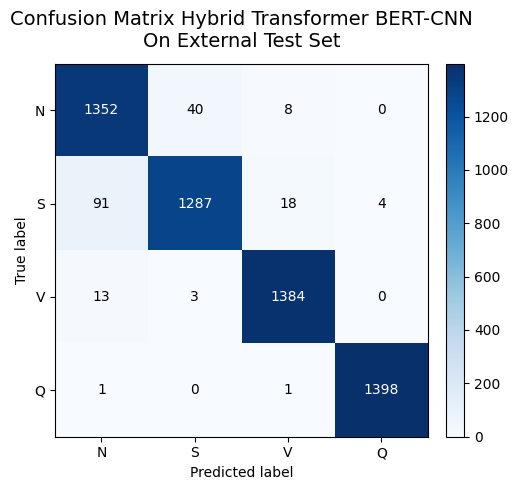

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

# === Folder simpan ===
save_dir = "hybrid_transformer_bert_cnn_non_tuning_external_outputs"
os.makedirs(save_dir, exist_ok=True)

# Confusion matrix (Hybrid Transformer BERT-CNN - External Test Set, Non-Tuning)
cm = np.array([
    [1352,  40,   8,   0],  # True N
    [  91, 1287, 18,   4],  # True S
    [  13,   3, 1384,  0],  # True V
    [   1,   0,   1, 1398]  # True Q
], dtype=int)

classes = ['N', 'S', 'V', 'Q']

# Plot sederhana tanpa grid
fig, ax = plt.subplots(figsize=(5.5, 5))
im = ax.imshow(cm, cmap='Blues', interpolation='nearest')

ax.set_title('Confusion Matrix Hybrid Transformer BERT-CNN\nOn External Test Set', pad=12, fontsize=14)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

# Colorbar
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Anotasi nilai di tiap sel
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f'{cm[i, j]}',
                ha='center', va='center',
                color='white' if cm[i, j] > thresh else 'black',
                fontsize=10)

plt.tight_layout()

# Simpan gambar
out_path = os.path.join(save_dir, 'hybrid_transformer_bert_cnn_nontuning_externaltest.png')
plt.savefig(out_path, dpi=150, bbox_inches='tight')
plt.show()
